## SETUP AND LIBRARIES

In [70]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import random
import boto3
import os
import copy

In [90]:
# Read file from S3
s3 = boto3.client('s3')
bucket = 'awsdriver'
file_key = 'ore_data.csv'

obj = s3.get_object(Bucket=bucket, Key=file_key)
ore_data_df = pd.read_csv(obj['Body'])

# Create a dictionary for ore data (grade: tonnage)
ore_data = {grade: ton for grade, ton in zip(ore_data_df['GRADE'], ore_data_df['TONNAGE'])}

In [75]:
# Get annual production tonnage from the user with error handling
while True:
    try:
        annual_production_ton = int(input("Enter annual production tonnage (500,000 - 2,000,000): "))
        if not 500000 <= annual_production_ton <= 2000000:
            raise ValueError("Production tonnage must be between 500,000 and 2,000,000.")
        break
    except ValueError as e:
        print(f"Invalid input: {e}")

Enter annual production tonnage (500,000 - 2,000,000):  2000000


## ANNUAL ORE GRADE TO BE PRODUCED
---

In [76]:
# Initial total tonnage
total_ton = sum(ore_data.values())

# Define production years
years_of_production = total_ton // annual_production_ton
last_year_production_ton = total_ton % annual_production_ton

# Create a list to store the results
results = []

def random_selection(ore_data, required_ton):
    selected_ores = []
    remaining_ton = required_ton

    while remaining_ton > 0 and ore_data:
        possible_grades = [grade for grade in ore_data if ore_data[grade] > 0]
        if not possible_grades:
            break
        grade = random.choice(possible_grades)
        ore_ton = ore_data[grade]
        tonnage_to_use = min(remaining_ton, ore_ton)

        if tonnage_to_use > 0:
            selected_ores.append((grade, tonnage_to_use))
            remaining_ton -= tonnage_to_use
            ore_data[grade] -= tonnage_to_use
            if ore_data[grade] == 0:
                del ore_data[grade]

    return selected_ores

def calculate_average_grade(selected_ores):
    total_ton = sum(ton for grade, ton in selected_ores)
    weighted_sum = sum(grade * ton for grade, ton in selected_ores)
    return weighted_sum / total_ton if total_ton else 0

remaining_ore_data = copy.deepcopy(ore_data)
grade_usage = {grade: [] for grade in ore_data.keys()}

for year in range(1, years_of_production + 2):
    if year == years_of_production + 1 and last_year_production_ton != 0:
        annual_production_ton = last_year_production_ton

    selected_ores = random_selection(remaining_ore_data, annual_production_ton)
    average_grade = calculate_average_grade(selected_ores)
    if selected_ores:
        results.append((year, annual_production_ton, round(average_grade, 1), selected_ores))

    for grade, ton in selected_ores:
        if grade in grade_usage:
            grade_usage[grade].append((year, ton))

df_results = pd.DataFrame(results, columns=["Year", "Annual Production (ton)", "Average Grade %", "Selected Ores"])
df_results['Annual Production (ton)'] = df_results['Annual Production (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
pd.set_option('display.max_colwidth', None)
df_results

,Year,Annual Production (ton),Average Grade %,Selected Ores
0,1,2.000.000,44.4,"[(55, 958800), (19, 101520), (23, 130848), (39, 304560), (31, 198528), (43, 305744)]"
1,2,2.000.000,42.6,"[(15, 85728), (33, 248160), (27, 180480), (51, 1015200), (41, 406080), (37, 64352)]"
2,3,2.000.000,43.1,"[(3, 45120), (5, 47376), (25, 157920), (47, 726432), (49, 857280), (35, 165872)]"
3,4,2.000.000,42.2,"[(29, 182736), (7, 56400), (9, 63168), (53, 1080960), (43, 258256), (17, 81216), (13, 76704), (37, 200560)]"
4,5,2.000.000,47.3,"[(21, 117312), (37, 73488), (45, 789600), (57, 902400), (35, 45008), (11, 72192)]"


## PRODUCT QUANTITY
---

In [77]:
def calculate_yield(grade):
    return -0.0004 * (grade ** 3) + 0.0461 * (grade ** 2) - 0.1765 * grade + 0.72

def calculate_product(annual_ton, average_grade):
    yield_value = calculate_yield(average_grade) / 100
    product = (annual_ton * yield_value)
    return product

def calculate_cost(grade):
    return 0.1 * grade + 3.7

def calculate_mining_cost(annual_production):
    return (-1e-06 * annual_production + 8.5) * annual_production

product_results = []

for year, annual_production_ton, average_grade, selected_ores in results:
    yield_value = calculate_yield(average_grade / 100)
    product = calculate_product(annual_production_ton, average_grade)
    p_cost = calculate_cost(average_grade) * product
    mining_cost = calculate_mining_cost(annual_production_ton)
    product_results.append((year, annual_production_ton, round(average_grade, 1), round(yield_value * 100, 1), int(product), int(p_cost), int(mining_cost)))

df_product_results = pd.DataFrame(product_results, columns=["Year", "Annual Production (ton)", "Average Grade %", "Yield (%)", "Product Quantity (ton)", "Processing Cost", "Mining Cost"])

df_product_results['Annual Production (ton)'] = df_product_results['Annual Production (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_product_results['Product Quantity (ton)'] = df_product_results['Product Quantity (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_product_results['Processing Cost'] = df_product_results['Processing Cost'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_product_results['Mining Cost'] = df_product_results['Mining Cost'].apply(lambda x: "{:,}".format(x).replace(",", "."))

total_waste_rock_cost = 150000000  # USD
number_of_years = df_product_results.shape[0]
waste_rock_cost_per_year = total_waste_rock_cost / number_of_years

df_product_results['Waste Rock Cost'] = waste_rock_cost_per_year
df_product_results['Waste Rock Cost'] = df_product_results['Waste Rock Cost'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
pd.set_option('display.max_colwidth', None)
df_product_results

,Year,Annual Production (ton),Average Grade %,Yield (%),Product Quantity (ton),Processing Cost,Mining Cost,Waste Rock Cost
0,1,2.000.000,44.4,65.1,975.034,7.936.783,13.000.000,30.000.000
1,2,2.000.000,42.6,65.3,918.760,7.313.333,13.000.000,30.000.000
2,3,2.000.000,43.1,65.2,934.469,7.485.100,13.000.000,30.000.000
3,4,2.000.000,42.2,65.4,906.156,7.176.762,13.000.000,30.000.000
4,5,2.000.000,47.3,64.7,1.063.621,8.966.332,13.000.000,30.000.000


## REVENUE
---

In [78]:
ore_prices = [120, 118, 119, 200, 111, 123, 124, 126, 125, 130, 120, 118, 119, 200, 111, 123, 124, 126, 125, 130]

def calculate_revenue(product_amounts, ore_prices):
    revenue_results = []
    total_revenue = 0
    for i, (year, annual_production_ton, avg_grade, yield_percentage, product_amount, _, _) in enumerate(product_amounts):
        price = ore_prices[i % len(ore_prices)]
        revenue = product_amount * price
        total_revenue += revenue
        revenue_results.append((year, round(avg_grade, 1), round(yield_percentage, 1), int(product_amount), int(revenue)))
    return revenue_results, total_revenue

revenue_results, total_revenue = calculate_revenue(product_results, ore_prices)

df_revenue_results = pd.DataFrame(revenue_results, columns=["Year", "Average Grade %", "Yield (%)", "Product Quantity (ton)", "Revenue (USD)"])

df_revenue_results['Product Quantity (ton)'] = df_revenue_results['Product Quantity (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_revenue_results['Revenue (USD)'] = df_revenue_results['Revenue (USD)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
pd.set_option('display.max_colwidth', None)
df_revenue_results

,Year,Average Grade %,Yield (%),Product Quantity (ton),Revenue (USD)
0,1,44.4,65.1,975.034,117.004.080
1,2,42.6,65.3,918.760,108.413.680
2,3,43.1,65.2,934.469,111.201.811
3,4,42.2,65.4,906.156,181.231.200
4,5,47.3,64.7,1.063.621,118.061.931


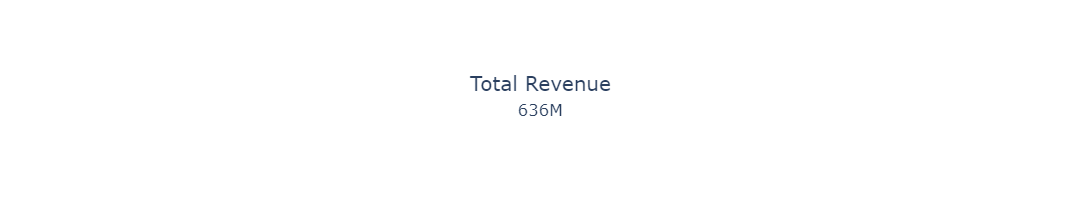

In [79]:
tr_fig = go.Figure()
tr_fig.add_trace(go.Indicator(mode="number", value=total_revenue, title={"text": "Total Revenue"}))
tr_fig.update_layout(height=200)
tr_fig.show()

## INVESTMENT AMOUNT FOR BENEFICIATION PLANT
---

In [82]:
def calculate_new_investment_cost(existing_cost, existing_capacity, new_capacity, factor=0.6):
    new_cost = existing_cost * (new_capacity / existing_capacity) ** factor
    return new_cost
    """
    Calculate the new investment cost using the six-tenths factor rule.
    
    :param existing_cost: Existing investment cost (C1)
    :param existing_capacity: Existing capacity (Q1)
    :param new_capacity: New capacity (Q2)
    :param factor: Six-tenths factor (default is 0.6)
    :return: New investment cost (C2)
    """
C1 = 10000000  # Existing investment cost (USD)
Q1 = 500000  # Existing capacity
Q2 = annual_production_ton  # New capacity
C2 = calculate_new_investment_cost(C1, Q1, Q2)

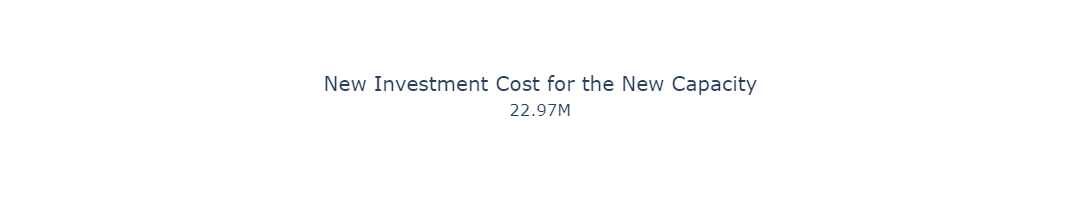

In [83]:
invest_fig = go.Figure()
invest_fig.add_trace(go.Indicator(mode="number", value=C2, title={"text": "New Investment Cost for the New Capacity"}))
invest_fig.update_layout(height=200)
invest_fig.show()

## PLANT LOAN REPAYMENT AMOUNTS
---

In [84]:
def calculate_annual_payment(principal, annual_interest_rate, years):
    r = annual_interest_rate / 100
    n = years
    annual_payment = (principal * r) / (1 - (1 + r) ** -n)
    return annual_payment

principal = C2  # new investment cost
annual_interest_rate = 5  # Annual interest rate (%)
years = 4  # Loan term (years)

annual_payment = calculate_annual_payment(C2, annual_interest_rate, years)

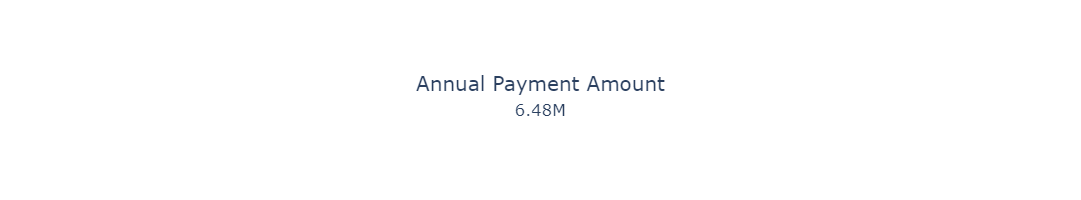

In [85]:
ap_fig = go.Figure()
ap_fig.add_trace(go.Indicator(mode="number", value=annual_payment, title={"text": "Annual Payment Amount"}))
ap_fig.update_layout(height=200)
ap_fig.show()

## NET INCOME
---

In [86]:
annual_payment = calculate_annual_payment(principal, annual_interest_rate, years)
df_revenue_results['Revenue (USD)'] = df_revenue_results['Revenue (USD)'].str.replace('.', '').str.replace(',', '.').astype(float)

processing_costs = df_product_results['Processing Cost'].str.replace('.', '').str.replace(',', '.').astype(float).tolist()
mining_costs = df_product_results['Mining Cost'].str.replace('.', '').str.replace(',', '.').astype(float).tolist()
waste_rock_costs = df_product_results['Waste Rock Cost'].str.replace('.', '').str.replace(',', '.').astype(float).tolist()

net_income_results = []
for i, (year, avg_grade, yield_percentage, product_amount, revenue) in enumerate(revenue_results):
    net_income = revenue - annual_payment - processing_costs[i] - mining_costs[i] - waste_rock_costs[i] if i < 4 else revenue - processing_costs[i] - mining_costs[i] - waste_rock_costs[i]
    net_income_results.append((
        year, avg_grade, yield_percentage, product_amount, revenue,
        int(annual_payment) if i < 4 else 0,
        int(processing_costs[i]), int(mining_costs[i]), int(waste_rock_costs[i]), 
        int(net_income)
    ))

df_net_income_results = pd.DataFrame(net_income_results, columns=[
    "Year", "Average Grade %", "Yield (%)", "Product Quantity (ton)", "Revenue (USD)", 
    "Annual Payment", "Processing Cost", "Mining Cost", "Waste Rock Cost", "Net Income (USD)"
])

df_net_income_results['Product Quantity (ton)'] = df_net_income_results['Product Quantity (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_net_income_results['Revenue (USD)'] = df_net_income_results['Revenue (USD)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_net_income_results['Annual Payment'] = df_net_income_results['Annual Payment'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_net_income_results['Processing Cost'] = df_net_income_results['Processing Cost'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_net_income_results['Mining Cost'] = df_net_income_results['Mining Cost'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_net_income_results['Waste Rock Cost'] = df_net_income_results['Waste Rock Cost'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_net_income_results['Net Income (USD)'] = df_net_income_results['Net Income (USD)'].apply(lambda x: "{:,}".format(x).replace(",", "."))

total_net_income = df_net_income_results['Net Income (USD)'].str.replace('.', '').str.replace(',', '.').astype(float).sum()
pd.set_option('display.max_colwidth', None)
df_net_income_results

,Year,Average Grade %,Yield (%),Product Quantity (ton),Revenue (USD),Annual Payment,Processing Cost,Mining Cost,Waste Rock Cost,Net Income (USD)
0,1,44.4,65.1,975.034,117.004.080,6.478.930,7.936.783,13.000.000,30.000.000,59.588.366
1,2,42.6,65.3,918.760,108.413.680,6.478.930,7.313.333,13.000.000,30.000.000,51.621.416
2,3,43.1,65.2,934.469,111.201.811,6.478.930,7.485.100,13.000.000,30.000.000,54.237.780
3,4,42.2,65.4,906.156,181.231.200,6.478.930,7.176.762,13.000.000,30.000.000,124.575.507
4,5,47.3,64.7,1.063.621,118.061.931,0,8.966.332,13.000.000,30.000.000,66.095.599


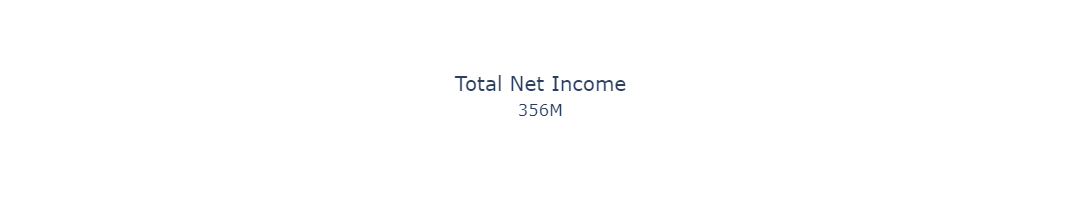

In [87]:
tni_fig = go.Figure()
tni_fig.add_trace(go.Indicator(mode="number",value=total_net_income,title={"text": "Total Net Income"},))
tni_fig.update_layout(height=200)
tni_fig.show()

## NET PRESENT VALUE
---

In [88]:
npv = 0
discount_rate = 0.1  # Define your discount rate here

for i in range(len(df_net_income_results)):
    discounted_net_income = float(df_net_income_results["Net Income (USD)"][i].replace('.', ''))
    npv += discounted_net_income / (1 + discount_rate) ** (i + 1)

net_present_value = npv - C2  # C2 is investment cost

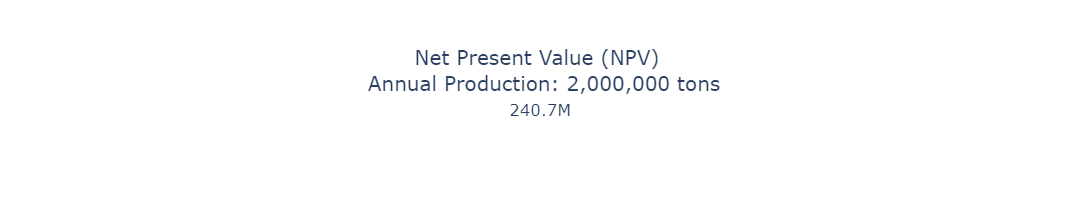

In [89]:
npv_fig = go.Figure()
npv_fig.add_trace(go.Indicator(
    mode="number",
    value=net_present_value,
    title={"text": f"Net Present Value (NPV) <br> Annual Production: {annual_production_ton:,} tons"},))
npv_fig.update_layout(height=200)
npv_fig.show()